In [1]:
pip install human-learn

     ------------------------------------ 116.4/116.4 kB 974.3 kB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

from hulearn.datasets import load_titanic
from sklearn.model_selection import GridSearchCV

In [3]:
df = load_titanic(as_frame=True)
X, y = df.drop(columns=['survived']), df['survived']

In [4]:
df.head()

,survived,pclass,name,sex,age,fare,sibsp,parch
0,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,0,0


In [7]:
def fare_based(dataf, threshold=10):
    return np.array(dataf['fare'] > threshold).astype(int)

In [8]:
fare_based(X)

array([0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,

In [9]:
from hulearn.classification import FunctionClassifier
mod = FunctionClassifier(fare_based, threshold=10)

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

grid = GridSearchCV(mod,
                   cv=2,
                   param_grid={'threshold': np.linspace(0, 100, 30)},
                   scoring={'accuracy': make_scorer(accuracy_score),
                           'precision': make_scorer(precision_score),
                           'recall': make_scorer(recall_score)},
                   refit = 'accuracy'
                )

grid.fit(X, y)

GridSearchCV(cv=2,
             estimator=FunctionClassifier(func=<function fare_based at 0x000002B350F0C4C0>,
                                          threshold=10),
             param_grid={'threshold': array([  0.        ,   3.44827586,   6.89655172,  10.34482759,
        13.79310345,  17.24137931,  20.68965517,  24.13793103,
        27.5862069 ,  31.03448276,  34.48275862,  37.93103448,
        41.37931034,  44.82758621,  48.27586207,  51.72413793,
        55.17241379,  58.62068966,  62.06896552,  65.51724138,
        68.96551724,  72.4137931 ,  75.86206897,  79.31034483,
        82.75862069,  86.20689655,  89.65517241,  93.10344828,
        96.55172414, 100.        ])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

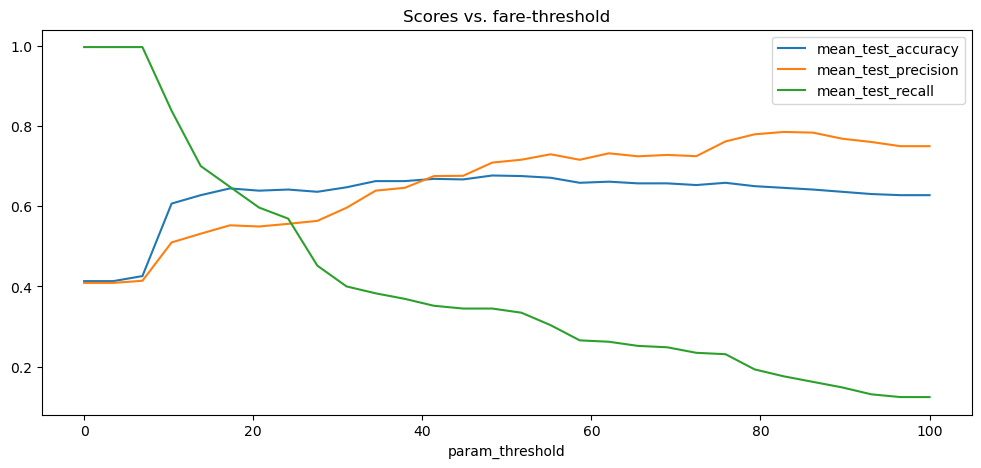

In [11]:
score_df = (pd.DataFrame(grid.cv_results_)
           .set_index('param_threshold')
           [['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']])

score_df.plot(figsize=(12, 5), title="Scores vs. fare-threshold");

In [12]:
import numpy as np
from hulearn.outlier import InteractiveOutlierDetector
from hulearn.classification import FunctionClassifier, InteractiveClassifier

outlier    = WhatEverOutlier().fit(X, y)
classifier = WhatEverClassifier().fit(X, y)

def make_decision(dataf, threshold=0.8):
    # First we create a resulting array with all the predictions
    res = classifier.predict(dataf)

    # If we detect doubt, "classify" it as a fallback instead.
    proba = classifier.predict_proba(dataf)
    res = np.where(proba.max(axis=1) < threshold, "doubt_fallback", res)

    # If we detect an ourier, we'll fallback too.
    res = np.where(outlier.predict(dataf) == -1, "outlier_fallback", res)

    # This `res` array contains the output of the drawn diagram.
    return res

fallback_model = FunctionClassifier(make_decision, threshold=0.8)

NameError: name 'WhatEverOutlier' is not defined

In [13]:
pip install scikit-lego

Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklego.datasets import load_penguins
from hulearn.experimental.interactive import InteractiveCharts

df = load_penguins(as_frame=True).dropna()

In [4]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male


In [21]:
from hulearn.experimental.interactive import InteractiveCharts
clf = InteractiveCharts(df, labels="species")

Loading BokehJS ...

In [22]:
clf.add_chart(x="bill_length_mm", y="bill_depth_mm")

In [24]:
clf.add_chart(x="flipper_length_mm", y="body_mass_g")

In [27]:
from hulearn.classification import InteractiveClassifier

model = InteractiveClassifier(json_desc=clf.data())

In [28]:
X, y = df.drop(columns=['species']), df['species']

preds = model.fit(X, y).predict_proba(X)

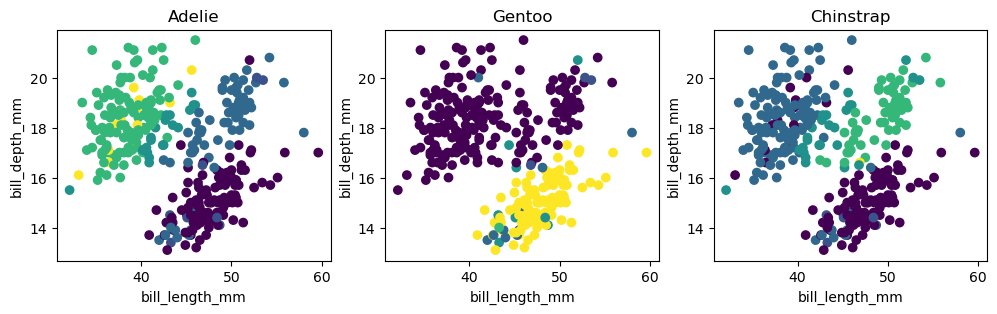

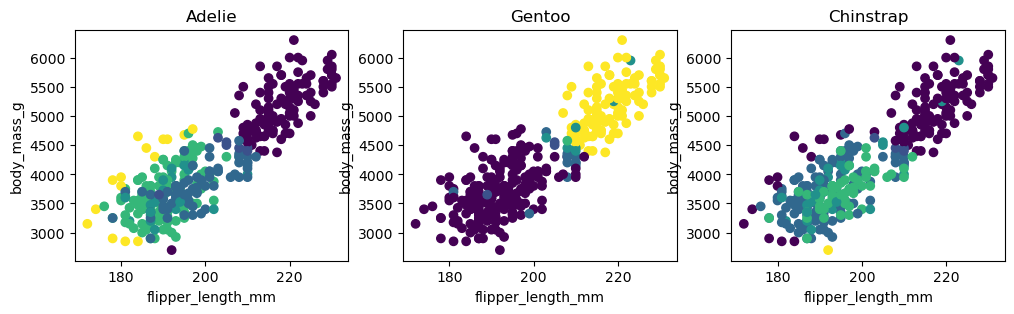

In [29]:
import matplotlib.pylab as plt

plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(131 + i)
    plt.scatter(X['bill_length_mm'], X['bill_depth_mm'], c=preds[:, i])
    plt.xlabel('bill_length_mm')
    plt.ylabel('bill_depth_mm')
    plt.title(model.classes_[i])
    
plt.figure(figsize=(12, 3))
for i in range(3):
    plt.subplot(131 + i)
    plt.scatter(X['flipper_length_mm'], X['body_mass_g'], c=preds[:, i])
    plt.xlabel('flipper_length_mm')
    plt.ylabel('body_mass_g')
    plt.title(model.classes_[i])